In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
from scipy import optimize as opt
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [10]:
# Распределение, из которого генерируем исследуемые параметры наших распределений
Beta_dist = sts.beta(1, 1)
opts = Beta_dist.rvs(3)

N = 1000
m = 50
sigm = 2.1
Bin_dist = sts.binom(m, opts[0])
Expon_dist = sts.expon(opts[1])
Norm_dist = sts.norm(opts[2], sigm)

Bin = Bin_dist.rvs(N)
Expon = Expon_dist.rvs(N)
Norm = Norm_dist.rvs(N)

opts

array([ 0.40908404,  0.46216649,  0.47303429])

Bin: эфф. оценка: $ p^* = \frac{\bar{X}}{m} $,  дополнительная оценка: $ p^* = \frac{X_1}{m} $

Expon: эфф. оценка: $ (\frac{1}{\lambda})^* = \bar{X} $,  дополнительная оценка: $ \lambda^* = \frac{n - 1}{X_1+\ldots+X_n} $

Norm: эфф. оценка: $ \mu^* = \bar{X} $,  дополнительная оценка: $ \mu^* = mediana(X)  $

In [11]:
# Считаем эффективные оценки 
bin_eff_ests = list(map(lambda n: np.mean(Bin[:n]) / m, range(1, N + 1) ))
exp_eff_ests = list(map(lambda n: np.mean(Expon[:n]), range(1, N + 1) ))
norm_eff_ests = list(map(lambda n: np.mean(Norm[:n]), range(1, N + 1) ))
# Считаем дополнительные оценки
bin_diff_ests = list(map(lambda n: Bin[0] / m, range(1, N + 1) ))
exp_diff_ests = list(map(lambda n: (n - 1) / np.sum(Expon[:n]), range(1, N + 1) ))
norm_diff_ests = list(map(lambda n: np.median(Norm[:n]), range(1, N + 1) ))

Посчитаем бутстрепную оценку дисперсии для эффективной оценки (параметрический бутстреп, количество бутстрепных выборок равно 500)

In [12]:
# Создаем массивы для параметрического бутстрепа для эффективных оценок
Bin_opt_dist_list = list(map(lambda n: sts.binom(m, bin_eff_ests[n]), range(N) ))
Expon_opt_dist_list = list(map(lambda n: sts.expon(1 / exp_eff_ests[n]), range(N) ))
Norm_opt_dist_list = list(map(lambda n: sts.norm(norm_eff_ests[n], sigm), range(N) ))
# Создаем массивы для параметрического бутстрепа для дополнительных оценок
Bin_opt1_dist_list = list(map(lambda n: sts.binom(m, bin_diff_ests[n]), range(N) ))
Expon_opt1_dist_list = list(map(lambda n: sts.expon(exp_diff_ests[n]), range(N) ))
Norm_opt1_dist_list = list(map(lambda n: sts.norm(norm_diff_ests[n], sigm), range(N) ))

In [13]:
K = 500
# Массивы, в которых будут выборочные оценки дисперсии параметров эфф. оценок
S_bin = []
S_exp = []
S_norm = []
# Массивы, в которых будут выборочные оценки дисперсии параметров доп. оценок
S_bin1 = []
S_exp1 = []
S_norm1 = []

In [14]:
%%time
for n in range(1, N):
    # Считаем наши эфф. оценки на К генерируемых бутстрепных выборках
    bin_ests = np.array(list(map(lambda k: np.mean( Bin_opt_dist_list[n].rvs(n) ) / m, range(K) )))
    exp_ests = np.array(list(map(lambda k: np.mean( Expon_opt_dist_list[n].rvs(n) ), range(K) )))
    norm_ests = np.array(list(map(lambda k: np.mean( Norm_opt_dist_list[n].rvs(n) ), range(K) )))
    # Добавляем в соответствующие массивы их выборочные дисперсии
    S_bin.append(np.mean((bin_ests)**2) - (np.mean(bin_ests))**2)    
    S_exp.append(np.mean((exp_ests)**2) - (np.mean(exp_ests))**2) 
    S_norm.append(np.mean((norm_ests)**2) - (np.mean(norm_ests))**2) 
    # Считаем наши доп. оценки на К генерируемых бутстрепных выборках
    bin1_ests = np.array(list(map(lambda k: Bin_opt1_dist_list[n].rvs(n)[0] / m, range(K) )))
    exp1_ests = np.array(list(map(lambda k: (n - 1) / np.sum( Expon_opt1_dist_list[n].rvs(n) ), range(K) )))
    norm1_ests = np.array(list(map(lambda k: np.median( Norm_opt1_dist_list[n].rvs(n) ), range(K) )))
    # Добавляем в соответствующие массивы их выборочные дисперсии
    S_bin1.append(np.mean((bin1_ests)**2) - (np.mean(bin1_ests))**2)    
    S_exp1.append(np.mean((exp1_ests)**2) - (np.mean(exp1_ests))**2) 
    S_norm1.append(np.mean((norm1_ests)**2) - (np.mean(norm1_ests))**2) 

CPU times: user 6min 45s, sys: 60 ms, total: 6min 45s
Wall time: 6min 45s


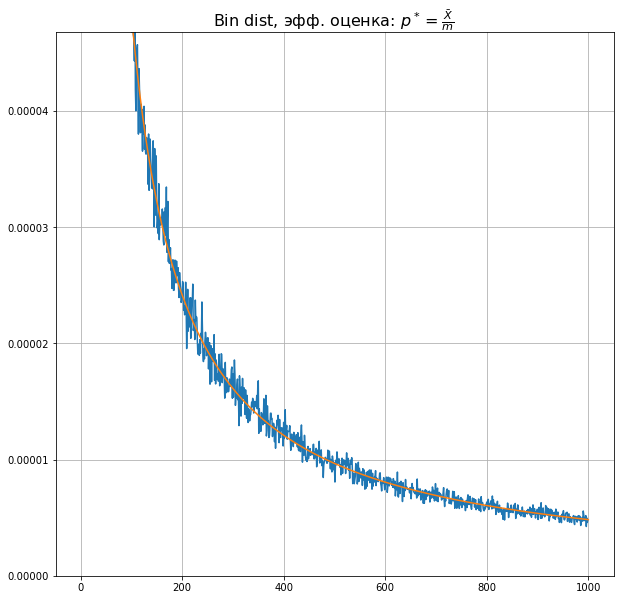

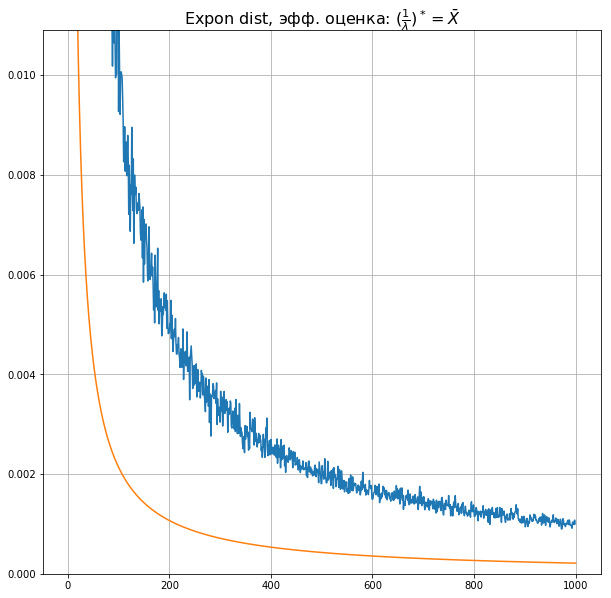

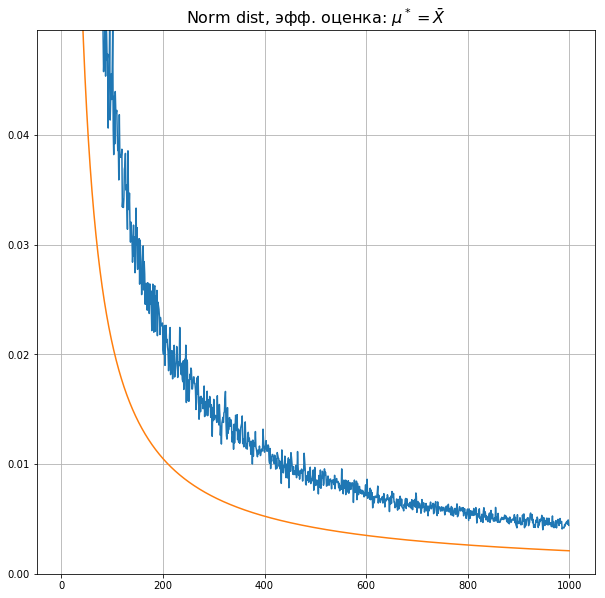

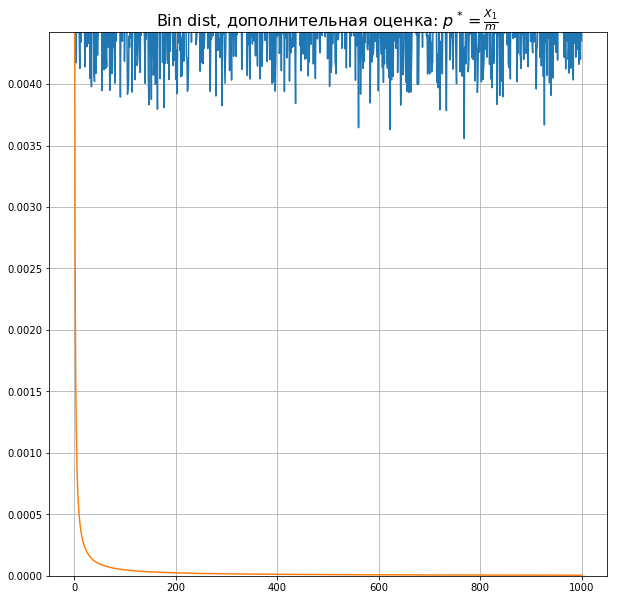

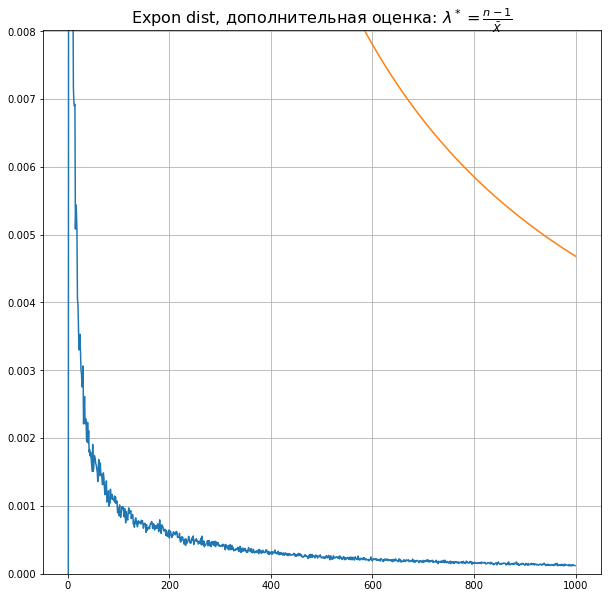

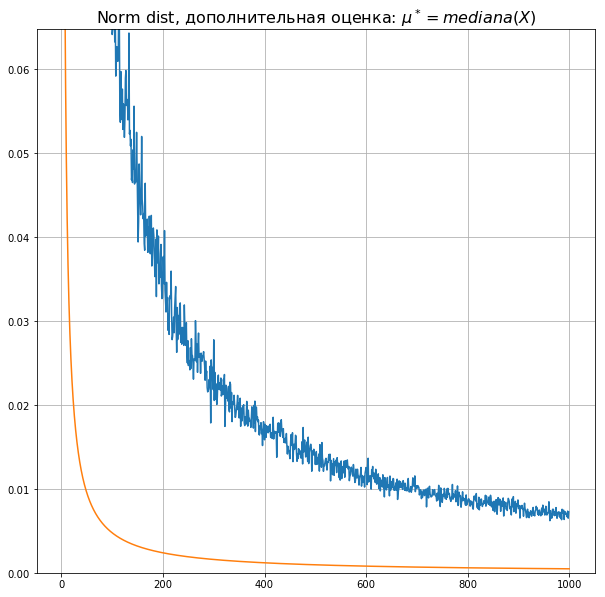

In [22]:
X_f = np.array(range(1, N))
X = np.linspace(1, 1000, 10000)
# Оценка дисперсии одного на один элемент из каждой из выборок
var_ests = [(opts[0] * (1 - opts[0])) / m, opts[1]**2, sigm, (opts[0] * (1 - opts[0])) / m, opts[1]**-2, 1/sigm] 
# Наши массивы дисперсий
S = [S_bin, S_exp, S_norm, 
     S_bin1, S_exp1, S_norm1]
names = ['Bin dist, эфф. оценка: $ p^* = \\frac{\\bar{X}}{m} $ ', 
        'Expon dist, эфф. оценка: $ (\\frac{1}{\\lambda})^* = \\bar{X} $', 
        'Norm dist, эфф. оценка: $ \\mu^* = \\bar{X} $', 
        'Bin dist, дополнительная оценка: $ p^* = \\frac{X_1}{m} $ ', 
        'Expon dist, дополнительная оценка: $ \\lambda^* = \\frac{n - 1}{\\bar{X}} $',  
        'Norm dist, дополнительная оценка: $ \\mu^* = mediana(X) $']
# Для каждой из оценок строим график
for var_est, s, name in zip(var_ests, S, names):
    plt.figure(figsize=(10,10))
    plt.subplot()
    plt.title(name, fontsize=16)
    plt.plot(X_f, s)
    plt.plot(X, var_est/X )
    plt.ylim(0, s[100] + s[10] * ('Expon dist, дополнительная оценка' in name))
    plt.grid()
    plt.show()

Для дополнительной оценки экспанентациального распределения бутстрепная оценка диспперсии может быть меньше, чем  величина, обратная к информации Фишера, потому что эта оценка не является несмещенной и для нее не должно выполняться неравенство Крамера-Рао.

Так же видим, что у нормального распределения дисперсии оценок выборочным средним и медианой очень похожи. Это логично, так как у распределений с симметричной плотностью выборочное среднее асимптотически ведет себя так же, как и медиана.

Видим, что в случае с биномиальным и экспанентациальным распределениями дисперсия эффективных оценок хорошо совпадает с обратной информацией Фишера, из чего видно, что эти оценки эффективные.

Дополнительная оценка для биномиального распределения -- это просто константа, поэтому логично, что ее дисперсия колеблется около одного значения.